# MLP, GBR, LR on MCR & MT Data

10 - 04 - 2023 | Plot the compared models

24 - 07 - 2023

27 - 08 - 2023 | Add the num of replicas

In [109]:
#from google.colab import drive
#drive.mount('/content/drive')

In [101]:
#file = r'/content/drive/MyDrive/Colab/microservice-prediction/dataset.csv'

Data

In [102]:
import pandas as pd
import numpy as np

file = r'dataset-mcr-rt-180000.csv'
df = pd.read_csv(file)

# dataset
dataset = df.values
X = dataset[:, 6] # mt column
print(np.min(X)," ",np.max(X))
print(len(X))
Y = dataset[:, 5] # mcr column
print(np.min(Y)," ",np.max(Y))
print(len(Y))

0.01   5858.833333333333
179996
0.0253444780071999   4874.2
179996


Reshape + Split

In [103]:
X = X.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_test_org = X_test
Y_test_org = Y_test
print(len(X_train), len(Y_train))
replica_actual = []
for i in range(len(X_test)):
    replica_actual.append(np.ceil(Y_test[i]*X_test[i]))

115196 115196


Model Evaluation

In [104]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(subsample=0.8,
                                learning_rate=0.4,
                                n_estimators=15,
                                max_depth=8,
                                min_samples_split=200, 
                                min_samples_leaf=40,
                                loss="absolute_error")
gbr.fit(X_train, Y_train)
Y_predict_gbr = gbr.predict(X_test)
replica_gbr = []
for i in range(len(X_test)):
    replica_gbr.append(np.ceil(Y_predict_gbr[i]*X_test[i]))

from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
Y_predict_lr = lr.predict(X_test)

replica_lr = []
for i in range(len(X_test)):
    replica_lr.append(np.ceil(Y_predict_lr[i]*X_test[i]))

MLP

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 2),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

mlp = MLP()

optimizer = optim.Adam(mlp.parameters(), lr=0.003)

criterion = nn.L1Loss()

X_train = torch.tensor(X_train.astype(np.float32))
Y_train = torch.tensor(Y_train.astype(np.float32))
X_val = torch.tensor(X_val.astype(np.float32))
Y_val = torch.tensor(Y_val.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))
Y_test = torch.tensor(Y_test.astype(np.float32))

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=64)
epochs = 3
losses = []

for epoch in range(epochs):
    mlp.train()
    epoch_loss = 0

    for input_data, target_data in train_loader:

        optimizer.zero_grad()
        # fp
        output = mlp(input_data)
        # loss
        loss = criterion(output, target_data.view(-1, 1))
        epoch_loss += loss.item()
        # bp
        loss.backward()
        # update
        optimizer.step()

    # avg loss
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # print
    if epoch % 1 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch, epochs, avg_loss))
mlp.eval()
with torch.no_grad():
    Y_predict_mlp = mlp(X_test)
    Y_predict_mlp = Y_predict_mlp.numpy()

replica_mlp = []

for i in range(len(X_test_org)):
    replica_mlp.append(np.ceil(Y_predict_mlp[i]*X_test_org[i]))

Epoch [0/3], Loss: 10.3513
Epoch [1/3], Loss: 9.6208
Epoch [2/3], Loss: 9.6167


Plots

In [106]:
'''import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

#print(np.shape(Y_predict_mlp), "  ", np.shape(Y_test))
plt.figure(figsize=(9, 5), dpi=120)

#https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/
X_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_test_org/1000)
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(np.arange(36000).min()/1000, np.arange(36000).max()/1000, 6)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="lightpink")

X_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_lr/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='LR Prediction', color="deeppink")

X_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_mlp/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='MLP Prediction', color="blue")

X_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_gbr/1000)
Y_ = X_Y_Spline(X_)
plt.subplot().tick_params(labelsize=20)
plt.plot(X_,Y_,  label='GBR Prediction', color="orange")
plt.ylabel('MCR [call/s] $\cdot\ 10^3$', fontsize=20)
plt.xlabel('Test data row $\cdot\ 10^3$', fontsize=20)
plt.legend( fontsize=20)
plt.show()'''

'import matplotlib.pyplot as plt\nfrom scipy.interpolate import make_interp_spline\n\n#print(np.shape(Y_predict_mlp), "  ", np.shape(Y_test))\nplt.figure(figsize=(9, 5), dpi=120)\n\n#https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/\nX_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_test_org/1000)\n# Returns evenly spaced numbers\n# over a specified interval.\nX_ = np.linspace(np.arange(36000).min()/1000, np.arange(36000).max()/1000, 6)\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_, label=\'Without prediction\', color="lightpink")\n\nX_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_lr/1000)\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_, label=\'LR Prediction\', color="deeppink")\n\nX_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_mlp/1000)\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_,  label=\'MLP Prediction\', color="blue")\n\nX_Y_Spline = make_interp_spline(np.arange(36000)/1000, Y_predict_gbr/1000)\nY_ = X_Y_Spline(X_)\nplt.subplot().tick_params(la

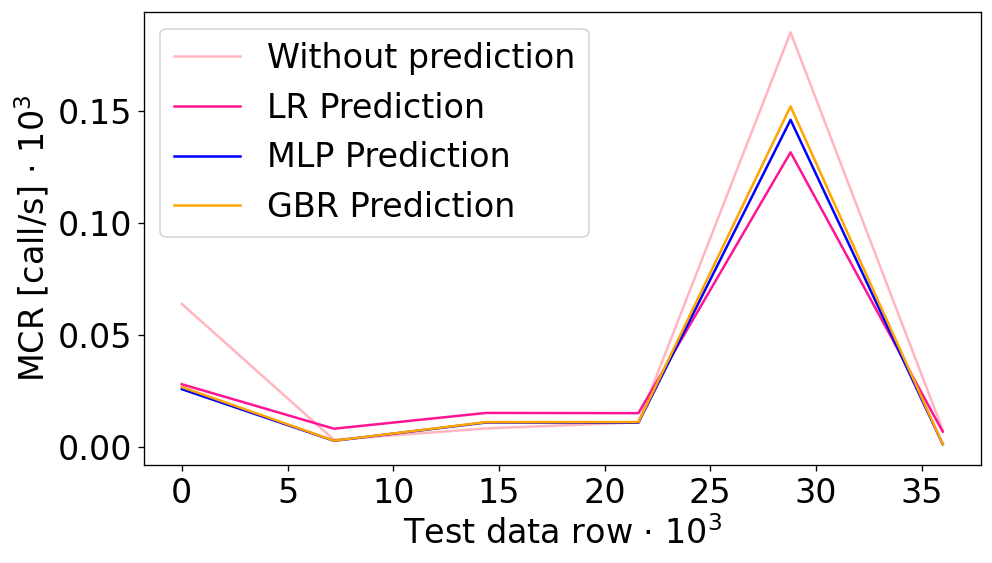

In [107]:
# Piecewise Cubic Hermite Interpolating Polynomial
from scipy.interpolate import pchip
plt.figure(figsize=(9, 5), dpi=120)

X_ = np.linspace(np.arange(36000).min()/1000, np.arange(36000).max()/1000, 6)
maxx = 0
index_max = 0
for i in range(len(Y_test_org)):
    if maxx <= Y_test_org[i]:
        maxx = Y_test_org[i]
        index_max = i
#print(Y_test_org[index_max])
X_Y_Spline = pchip(np.arange(36000)/1000, Y_test_org/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="lightpink")

X_Y_Spline = pchip(np.arange(36000)/1000, Y_predict_lr/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='LR Prediction', color="deeppink")

X_Y_Spline = pchip(np.arange(36000)/1000, Y_predict_mlp/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='MLP Prediction', color="blue")

X_Y_Spline = pchip(np.arange(36000)/1000, Y_predict_gbr/1000)
Y_ = X_Y_Spline(X_)
plt.subplot().tick_params(labelsize=20)
plt.plot(X_,Y_,  label='GBR Prediction', color="orange")
plt.ylabel('MCR [call/s] $\cdot\ 10^3$', fontsize=20)
plt.xlabel('Test data row $\cdot\ 10^3$', fontsize=20)
plt.legend( fontsize=20)
plt.show()


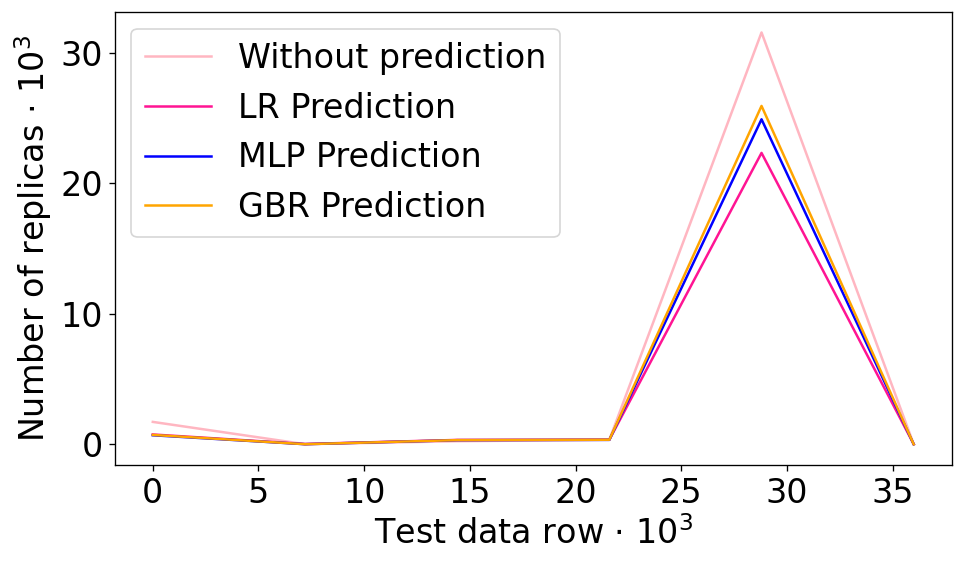

In [108]:
from scipy.interpolate import pchip

plt.figure(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)

X_ = np.linspace(np.arange(36000).min()/1000, np.arange(36000).max()/1000, 6)

X_Y_Spline = pchip(np.arange(36000)/1000, np.array(replica_actual)/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="lightpink")

X_Y_Spline = pchip(np.arange(36000)/1000, np.array(replica_lr)/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='LR Prediction', color="deeppink")

X_Y_Spline = pchip(np.arange(36000)/1000, np.array(replica_mlp)/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='MLP Prediction', color="blue")

X_Y_Spline = pchip(np.arange(36000)/1000, np.array(replica_gbr)/1000)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='GBR Prediction', color="orange")

plt.ylabel('Number of replicas $\cdot\ 10^3$', fontsize=20)
plt.xlabel('Test data row $\cdot\ 10^3$', fontsize=20)
plt.legend( fontsize=20)
plt.show()